 ## Exploration Notebook 
        
This notebook is where we prototype data ingestion, cleaning, quality checks, and quick visualizations.

**Before production-izing into `src/` folder and the Streamlit dashboard.**

In [ ]:
# Install Dependencies

!pip install pandas requests pyyaml plotly streamlit matplotlib seaborn statsmodels nbformat ipython


In [2]:
import sys
from pathlib import Path

# add src/ to import path so we can import our modules
sys.path.append(str(Path("../src").resolve()))

import pandas as pd
import requests
import yaml


from data_fetcher import fetch_historical_weather, fetch_historical_energy
from data_processor import clean_weather, clean_energy, merge_weather_energy
from data_quality_report import generate_report


In [3]:
# Load API keys & city list
config = yaml.safe_load(open("../config/config.yaml"))
config


{'noaa_token': 'hnEImeHklWePrAQiNbFMvcUgwOBFTHKW',
 'eia_key': '7nwnphm8ojtAysdsf7Yr8SsifByzVtR4CjeG77TF',
 'cities': [{'name': 'New York',
   'station_id': 'GHCND:USW00094728',
   'region': 'NYIS'},
  {'name': 'Chicago', 'station_id': 'GHCND:USW00094846', 'region': 'PJM'},
  {'name': 'Houston', 'station_id': 'GHCND:USW00012960', 'region': 'ERCO'},
  {'name': 'Phoenix', 'station_id': 'GHCND:USW00023183', 'region': 'AZPS'},
  {'name': 'Seattle', 'station_id': 'GHCND:USW00024233', 'region': 'CISO'}]}

In [5]:
# Pick first city for prototyping
city = config["cities"][0]
slug = city["name"].lower().replace(" ", "_")

# Fetch raw weather and energy
df_w = fetch_historical_weather(
    station_id=city["station_id"],
    days=90,
    token=config["noaa_token"]
)
df_e = fetch_historical_energy(
    region=city["region"],
    days=90,
    api_key=config["eia_key"]
)

# Preview
df_w.head(), df_e.head()


(datatype                 date   TMAX   TMIN
 0         2025-05-05T00:00:00  60.98  57.02
 1         2025-05-06T00:00:00  64.04  57.02
 2         2025-05-07T00:00:00  73.94  55.04
 3         2025-05-08T00:00:00  78.08  60.08
 4         2025-05-09T00:00:00  60.08  51.08,
          date respondent                       respondent-name type type-name  \
 0  2025-05-06       NYIS  New York Independent System Operator    D    Demand   
 1  2025-05-06       NYIS  New York Independent System Operator    D    Demand   
 2  2025-05-06       NYIS  New York Independent System Operator    D    Demand   
 3  2025-05-06       NYIS  New York Independent System Operator    D    Demand   
 4  2025-05-06       NYIS  New York Independent System Operator    D    Demand   
 
    timezone timezone-description  demand    value-units  
 0   Arizona              Arizona  360106  megawatthours  
 1   Central              Central  362853  megawatthours  
 2   Eastern              Eastern  365045  megawatthours  

In [6]:
print(f"Weather shape: {df_w.shape}, Energy shape: {df_e.shape}")
print("Missing in weather:\n", df_w.isna().sum())
print("Missing in energy:\n", df_e.isna().sum())


Weather shape: (86, 3), Energy shape: (1759, 9)
Missing in weather:
 datatype
date    0
TMAX    0
TMIN    0
dtype: int64
Missing in energy:
 date                    0
respondent              0
respondent-name         0
type                    0
type-name               0
timezone                0
timezone-description    0
demand                  0
value-units             0
dtype: int64


In [7]:
# Clean and merge
cw = clean_weather(df_w)
ce = clean_energy(df_e)
df_combined = merge_weather_energy(cw, ce)

# Preview
df_combined.head()


,date,TMAX,TMIN,respondent,respondent-name,type,type-name,timezone,timezone-description,demand,value-units
0,2025-05-06,64.04,57.02,NYIS,New York Independent System Operator,D,Demand,Arizona,Arizona,360106,megawatthours
1,2025-05-07,73.94,55.04,NYIS,New York Independent System Operator,D,Demand,Arizona,Arizona,357887,megawatthours
2,2025-05-08,78.08,60.08,NYIS,New York Independent System Operator,D,Demand,Arizona,Arizona,369593,megawatthours
3,2025-05-09,60.08,51.08,NYIS,New York Independent System Operator,D,Demand,Arizona,Arizona,371722,megawatthours
4,2025-05-10,71.96,50.00,NYIS,New York Independent System Operator,D,Demand,Arizona,Arizona,318627,megawatthours


In [8]:
print(f"Processed shape: {df_combined.shape}")
print("Processed missing:\n", df_combined.isna().sum())


Processed shape: (85, 11)
Processed missing:
 date                    0
TMAX                    0
TMIN                    0
respondent              0
respondent-name         0
type                    0
type-name               0
timezone                0
timezone-description    0
demand                  0
value-units             0
dtype: int64


In [9]:
# Generate data quality report
import json

report = generate_report()
print(json.dumps(report, indent=2))


{}


In [10]:
# Visualize TMAX vs Demand using Plotly
import plotly.express as px

fig = px.scatter(
    df_combined,
    x="TMAX", y="demand",
    trendline="ols",
    title="TMAX vs Demand"
)
fig.show()


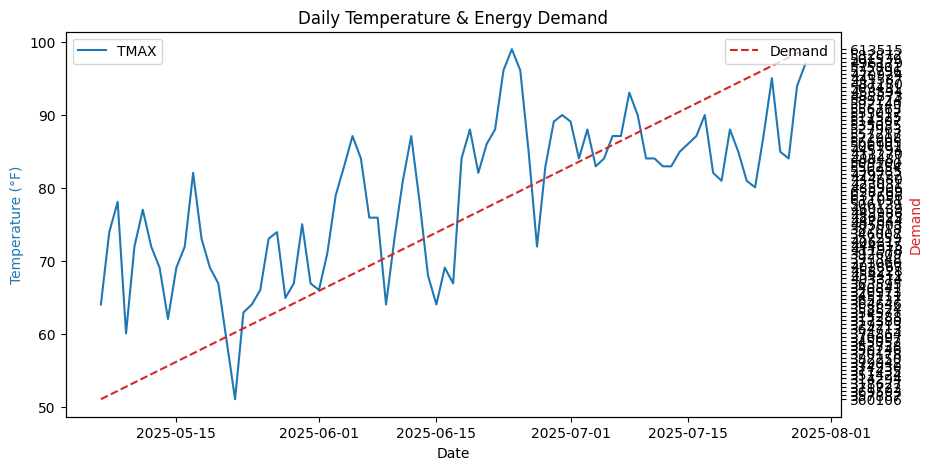

In [11]:
# Visualize TMAX vs Demand using Matplotlib
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,5))
ax2 = ax1.twinx()

ax1.plot(df_combined["date"], df_combined["TMAX"], label="TMAX", color="tab:blue")
ax2.plot(df_combined["date"], df_combined["demand"], label="Demand", linestyle="--", color="tab:red")

ax1.set_xlabel("Date")
ax1.set_ylabel("Temperature (°F)", color="tab:blue")
ax2.set_ylabel("Demand", color="tab:red")
plt.title("Daily Temperature & Energy Demand")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()


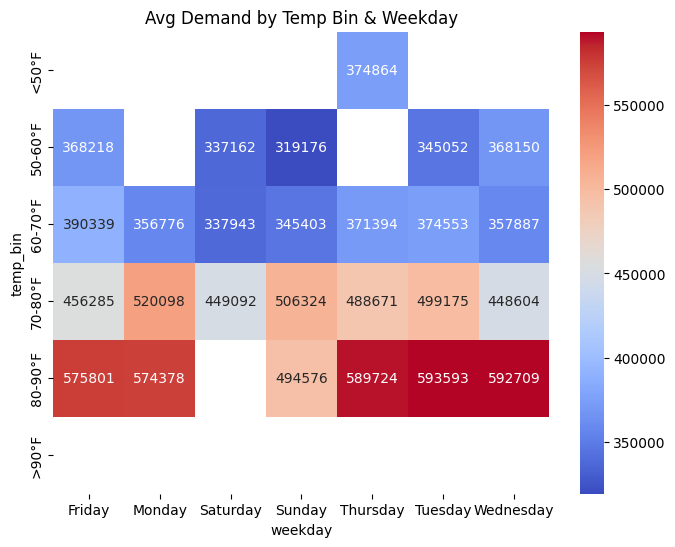

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

df_h = df_combined.copy()

# 1) Ensure demand is numeric
df_h["demand"] = pd.to_numeric(df_h["demand"], errors="coerce")

# 2) Compute weekday and temperature bin
df_h["weekday"] = df_h["date"].dt.day_name()
df_h["temp_bin"] = pd.cut(
    (df_h["TMAX"] + df_h["TMIN"]) / 2,
    bins=[-float("inf"), 50, 60, 70, 80, 90, float("inf")],
    labels=["<50°F", "50-60°F", "60-70°F", "70-80°F", "80-90°F", ">90°F"]
)

# 3) Group & pivot, explicitly including all categories
pivot = (
    df_h
    .groupby(["temp_bin", "weekday"], observed=False)["demand"]
    .mean()
    .reset_index()
    .pivot(index="temp_bin", columns="weekday", values="demand")
)

# 4) Plot
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="coolwarm")
plt.title("Avg Demand by Temp Bin & Weekday")
plt.show()


In [17]:
import plotly.express as px

# 1) Ensure demand is numeric
df_combined["demand"] = pd.to_numeric(df_combined["demand"], errors="coerce")

# 2) City coordinates dictionary
city_coords = {
    "new_york": {"lat": 40.7128, "lon": -74.0060},
    "chicago":  {"lat": 41.8781, "lon": -87.6298},
    "houston":  {"lat": 29.7604, "lon": -95.3698},
    "phoenix":  {"lat": 33.4484, "lon": -112.0740},
    "seattle":  {"lat": 47.6062, "lon": -122.3321},
}

# 3) Build a small DataFrame for the latest demand of our single city
latest = df_combined.iloc[-1]
map_df = pd.DataFrame([{
    "City": city["name"],
    "lat":  city_coords[slug]["lat"],
    "lon":  city_coords[slug]["lon"],
    "demand": latest["demand"]
}])

# 4) Plot
fig_map = px.scatter_geo(
    map_df,
    lat="lat",
    lon="lon",
    scope="usa",
    size="demand",
    hover_name="City",
    title="Latest Daily Demand by City"
)
fig_map.show()
